In [3]:
from matplotlib import pyplot as plt
import pandas as pd 
import netCDF4
fp='era5dara_194001.nc' # your file name with the eventual path
nc = netCDF4.Dataset(fp) # reading the nc file and creating Dataset
""" in this dataset each component will be 
in the form nt,nz,ny,nx i.e. all the variables will be flipped. """



' in this dataset each component will be \nin the form nt,nz,ny,nx i.e. all the variables will be flipped. '

In [13]:
import xarray as xr
import metpy.calc as mc
import numpy as np

def saturation_sh(T, p):
    T0  = 0.0                          
    Tm = -40.0                         
    a = (T - Tm) / (T0 - Tm)
    a = np.where(T > 0, 1.0, a)
    a = np.where(T < Tm, 0.0, a)
    b = 1 - a
    es = a * (6.11374*np.exp((0.0000045*p)+17.625*T/(T+243.04))) + \
         b * (6.10489*np.exp(0.000008*p+22.587*T/(T+273.86)))
    qs = 0.622 * es / (p - 0.378 * es)
    return qs

year = 2021
month = 11
day = 14
hour = 0

p_top = 200     #upper integration limit in hPa

# constants:
g = 9.80665   
R = 287.0     
tcoef = g / (R * np.log(2)) 
intc = 100.0 / (2 * g)  


dfs = xr.open_dataset(f'ERA5_sl_{year}{month:02d}{day:02d}_{hour:02d}00utc.nc')
dfp = xr.open_dataset(f'ERA5_pl_{year}{month:02d}{day:02d}_{hour:02d}00utc.nc')


levs = dfp.level.values
nlevs = len(levs)
pp = dfp.level.broadcast_like(dfp.q[0, :, :, :]).values



# near-surface variables needed for vertical integrations
p_sfc = dfs.sp[0, :, :].values / 100 
td_2m = dfs.d2m[0, :, :].values - 273.15
sh_2m = saturation_sh(td_2m, p_sfc)      
tt_2m = dfs.t2m[0, :, :].values - 273.15 
ssh_2m = saturation_sh(tt_2m, p_sfc)     
uu_10m = dfs.u10[0, :, :].values        
vv_10m = dfs.v10[0, :, :].values         

# pressure-level variables for vertical integrations
sh = dfp.q[0, :, :, :].values           
tt = dfp.t[0, :, :, :].values - 273.15   
ssh = saturation_sh(tt, pp)              
uu = dfp.u[0, :, :, :].values            
vv = dfp.v[0, :, :, :].values           

pscheck = np.where(p_sfc < levs[0], 0, 1)
dp = (p_sfc - levs[0]) * pscheck

# first-level (1000 hPa) data
sh1  = sh[0, :, :]
ssh1 = ssh[0, :, :]
uu1  = uu[0, :, :]
vv1  = vv[0, :, :]

# integration formula: iwv = ((sh_sfc + sh1)/2) * dp
IWV  = (sh_2m + sh1) * dp
ISWV = (ssh_2m + ssh1) * dp
Qu   = ((uu_10m * sh_2m) + (uu1 * sh1)) * dp
Qv   = ((vv_10m * sh_2m) + (vv1 * sh1)) * dp

#vertical integration up to ptop
for k in range(1, nlevs):
    pscheck = pscheck + np.where(p_sfc < levs[k], 0, 1)
    dp = np.where(pscheck < 1, 0, (p_sfc - levs[k]))
    dp = np.where(pscheck > 1, (levs[k-1] - levs[k]), dp)
    sh0 = np.where(pscheck < 1, sh_2m, sh1)
    ssh0 = np.where(pscheck < 1, ssh_2m, ssh1)
    uu0 = np.where(pscheck < 1, uu_10m, uu1)
    vv0 = np.where(pscheck < 1, vv_10m, vv1)

    #curr level
    sh1  = sh[k, :, :]
    ssh1 = ssh[k, :, :]
    uu1  = uu[k, :, :]
    vv1  = vv[k, :, :]

    #stepwise integration
    IWV  += (sh0 + sh1) * dp
    ISWV += (ssh0 + ssh1) * dp
    Qu   += ((uu0 * sh0) + (uu1 * sh1)) * dp
    Qv   += ((vv0 * sh0) + (vv1 * sh1)) * dp


IWV = intc * IWV
ISWV = intc * ISWV
Qu = intc * Qu
Qv = intc * Qv


CRH = IWV / ISWV


TPR = 3600 * (dfs.crr[0, :, :].values + dfs.csfr[0, :, :].values + \
              dfs.lsrr[0, :, :].values + dfs.lssfr[0, :, :].values)


WS10m = np.sqrt(uu_10m**2 + vv_10m**2)
WG10m = dfs.fg10[0, :, :]
GWS10m = np.where(WG10m < WS10m, WS10m, WG10m)

# LTMT
LTMT = tcoef * (mc.geopotential_to_height(dfp.z.sel(level=500)) -
       mc.geopotential_to_height(dfp.z.sel(level=1000)))[0, :, :].values

# MSLP and T2m
MSLP = dfs.msl[0, :, :].values
T2m = dfs.t2m[0, :, :].values


df1 = xr.open_dataset('ERA5_hrly_tp_20211114.nc')
df0 = xr.open_dataset('ERA5_hrly_tp_20211113.nc')
TP6H = df1.tp[0,:,:].values + df0.tp[19:24,:,:].sum(axis=0).values
"""
For TP6H valid at 0600, 1200, 1800 UTC 14 Nov 2021, use the following commands:
TP6H = df1.tp[1:7,:,:].sum(axis=0).values   # (valid at 0600 UTC)
TP6H = df1.tp[7:13,:,:].sum(axis=0).values  # (valid at 1200 UTC)
TP6H = df1.tp[13:19,:,:].sum(axis=0).values # (valid at 1800 UTC)
"""
TP6H = 1000 * TP6H         
ti = 4 * (day - 1) + hour // 6
dfa = xr.open_dataset(f'out_{year}{month:02d}.nc')
ARS = dfa.shape[0,ti,0,:,:].values
ARS = np.where(ARS > 0, 1, 0)          # (0 for non-AR and 1 for AR)
mdfa = xr.open_dataset(f'mout_{year}{month:02d}.nc')
MARS = mdfa.shape[0,ti,0,:,:].values
MARS = np.where(MARS > 0, 1, 0)        # (0 for non-AR and 1 for AR)

# statistics
print("-----------------------------")
print(f"Minimum and maximum of Qu: {Qu.min()}, {Qu.max()} kg m**-1 s**-1")
print(f"Minimum and maximum of Qv: {Qv.min()}, {Qv.max()} kg m**-1 s**-1")
print(f"Minimum and maximum of IWV: {IWV.min()}, {IWV.max()} kg m**-2")
print(f"Minimum and maximum of CRH: {CRH.min()}, {CRH.max()}")
print(f"Minimum and maximum of TPR: {TPR.min()}, {TPR.max()} mm/h")
print(f"Minimum and maximum of TP6H: {TP6H.min()}, {TP6H.max()} mm")
print(f"Minimum and maximum of GWS10m: {GWS10m.min()}, {GWS10m.max()} m/s")
print(f"Minimum and maximum of LTMT: {LTMT.min()}, {LTMT.max()} K")
print(f"Minimum and maximum of T2m: {T2m.min()}, {T2m.max()} K")
print(f"Minimum and maximum of MSLP: {MSLP.min()}, {MSLP.max()} Pa")
print(f"Minimum and maximum of ARS: {np.min(ARS)}, {np.max(ARS)}")
print(f"Minimum and maximum of MARS: {np.min(MARS)}, {np.max(MARS)}")
print("Well done!")
print("-------------------------------")

# Close the files
dfs.close()
dfp.close()
dfa.close()

-----------------------------
Minimum and maximum of Qu: -769.323264137833, 1152.280005627042 kg m**-1 s**-1
Minimum and maximum of Qv: -703.3547784132415, 991.4305949963025 kg m**-1 s**-1
Minimum and maximum of IWV: 0.11504041321961497, 71.46134645312091 kg m**-2
Minimum and maximum of CRH: 0.028475346680423574, 1.071513983051957
Minimum and maximum of TPR: -3.903127820947816e-16, 30.961274000532857 mm/h
Minimum and maximum of TP6H: -1.734723475976807e-14, 144.66455051045557 mm
Minimum and maximum of GWS10m: 0.3739773727006508, 38.9011116027832 m/s
Minimum and maximum of LTMT: 241.1008853526944, 288.6906662692292 K
Minimum and maximum of T2m: 218.6726837158203, 308.1707305908203 K
Minimum and maximum of MSLP: 92870.75, 104538.25 Pa
Minimum and maximum of ARS: 0, 1
Minimum and maximum of MARS: 0, 1
Well done!
-------------------------------


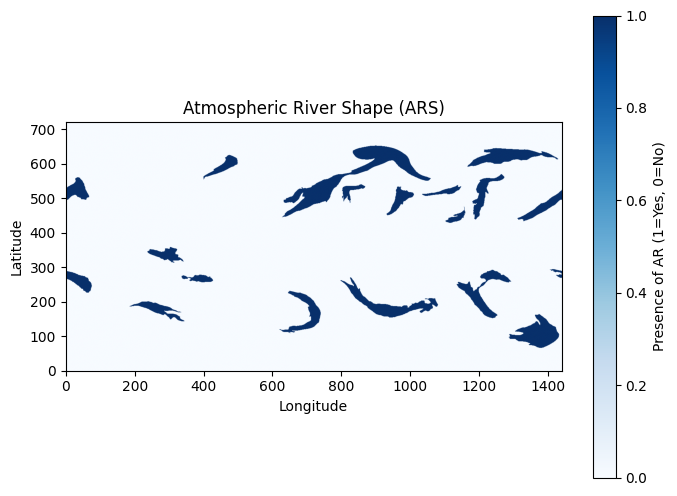

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.imshow(MARS, cmap='Blues', origin='lower')
plt.title('Atmospheric River Shape (ARS)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.colorbar(label='Presence of AR (1=Yes, 0=No)')
plt.show()

In [28]:
print(nc)
print(nc.variables.keys())

#plt.imshow(nc['IWV']) 
""" imshow is a 2D plot function
according to what I have said before this will plot the second
iteration of the vertical slize with y = 0, one of the vertical
boundaries of your model. """
#plt.show()

<class 'netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: An ERA5-based Dataset for Atmospheric River Analysis in January 1940
    author: Ruping Mo (ruping.mo@ec.gc.ca)
    institution: Meteorological Service of Canada, Environment and Climate Change Canada
    history: Created at 2024-06-07T05:18:12.775076.
    summary: This is a 6-hourly global dataset through January 1940, tailored to facilitate analysis of various aspects of the atmospheric river system. It is based on the fifth generation ECMWF reanalysis (ERA5).
    dimensions(sizes): longitude(1440), latitude(721), time(124)
    variables(dimensions): float32 longitude(longitude), float32 latitude(latitude), float32 time(time), float32 Qu(time, latitude, longitude), float32 Qv(time, latitude, longitude), float32 IWV(time, latitude, longitude), float32 CRH(time, latitude, longitude), float32 TPR(time, latitude, longitude), float32 TP6H(time, latitude, longitude), float32 GWS10m(time, latitude, longi

' imshow is a 2D plot function\naccording to what I have said before this will plot the second\niteration of the vertical slize with y = 0, one of the vertical\nboundaries of your model. '

IWV shape: (124, 721, 1440)


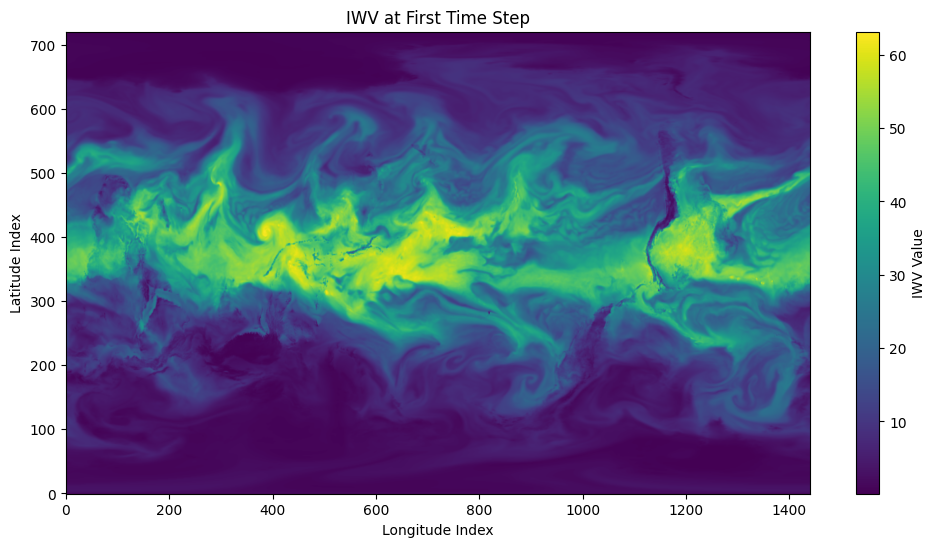

In [29]:
if 'IWV' in nc.variables:
    iwv_data = nc.variables['IWV'][:] 
    print("IWV shape:", iwv_data.shape)  

    iwv_slice = iwv_data[0, :, :] 


    plt.figure(figsize=(12, 6))
    plt.imshow(iwv_slice, cmap='viridis', origin='lower', aspect='auto')
    plt.colorbar(label='IWV Value')
    plt.title('IWV at First Time Step')
    plt.xlabel('Longitude Index')
    plt.ylabel('Latitude Index')
    plt.show()
else:
    print("Variable 'IWV' not found in the dataset.")

Qu shape: (124, 721, 1440)


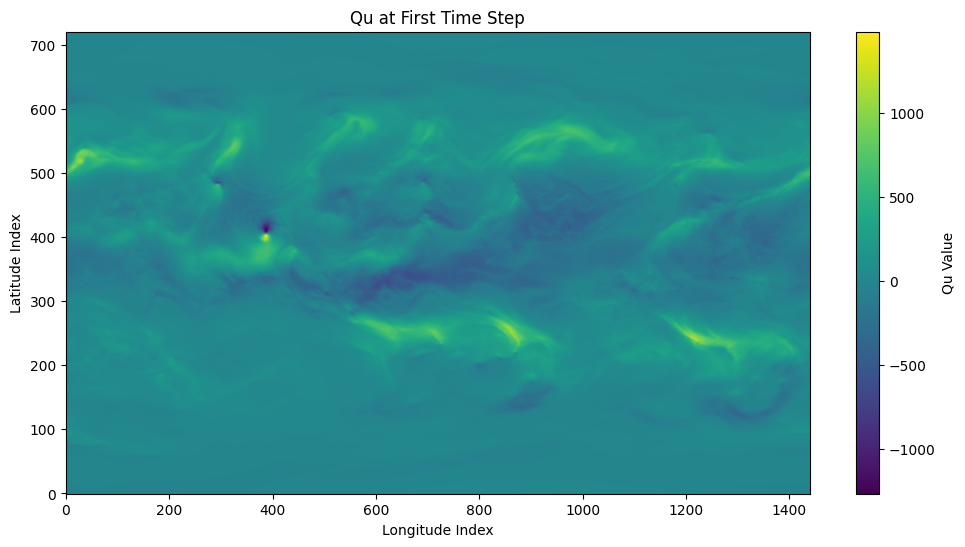

In [30]:
if 'IWV' in nc.variables:
    qu_data = nc.variables['Qu'][:]  
    print("Qu shape:", qu_data.shape) 

    qu_slice = qu_data[0, :, :]
    
    plt.figure(figsize=(12, 6))
    plt.imshow(qu_slice, cmap='viridis', origin='lower', aspect='auto')
    plt.colorbar(label='Qu Value')
    plt.title('Qu at First Time Step')
    plt.xlabel('Longitude Index')
    plt.ylabel('Latitude Index')
    plt.show()
else:
    print("Variable 'IWV' not found in the dataset.")

Qv shape: (124, 721, 1440)


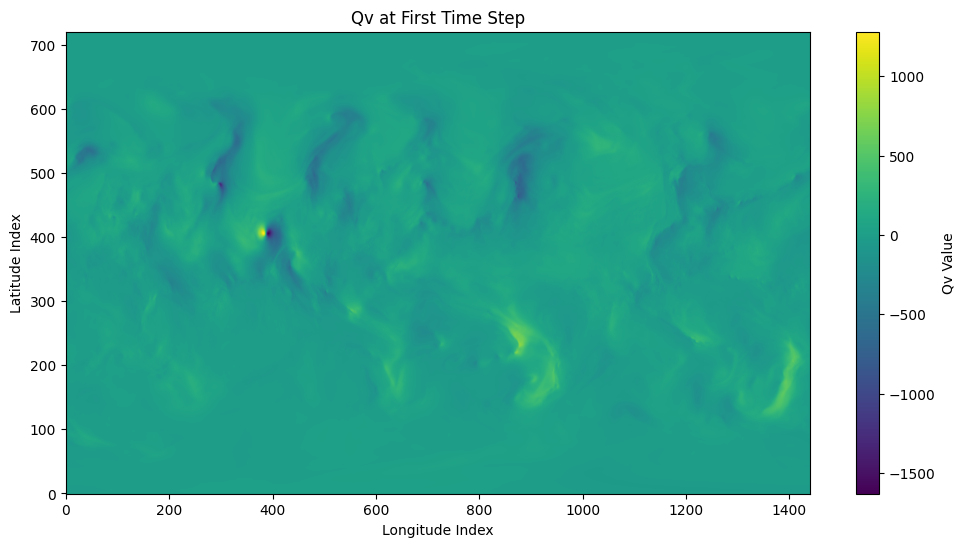

In [31]:
if 'Qv' in nc.variables:
    qv_data = nc.variables['Qv'][:] 
    print("Qv shape:", qv_data.shape) 

    qv_slice = qv_data[0, :, :]  

     
    plt.figure(figsize=(12, 6))
    plt.imshow(qv_slice, cmap='viridis', origin='lower', aspect='auto')
    plt.colorbar(label='Qv Value')
    plt.title('Qv at First Time Step')
    plt.xlabel('Longitude Index')
    plt.ylabel('Latitude Index')
    plt.show()
else:
    print("Variable 'Qv' not found in the dataset.")

CRH shape: (124, 721, 1440)


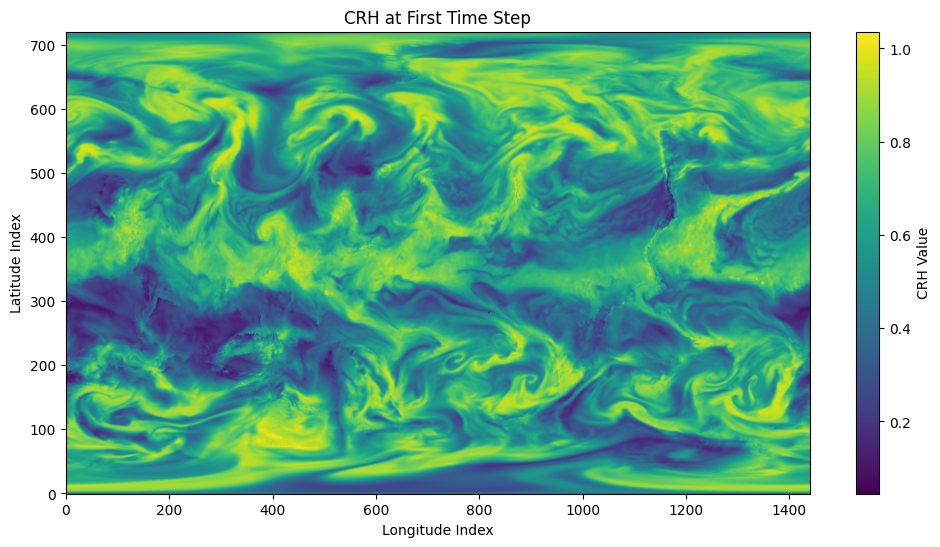

In [32]:
if 'CRH' in nc.variables:
    crh_data = nc.variables['CRH'][:]   
    print("CRH shape:", crh_data.shape)  

 
    crh_slice = crh_data[0, :, :]   

 
    plt.figure(figsize=(12, 6))
    plt.imshow(crh_slice, cmap='viridis', origin='lower', aspect='auto')
    plt.colorbar(label='CRH Value')
    plt.title('CRH at First Time Step')
    plt.xlabel('Longitude Index')
    plt.ylabel('Latitude Index')
    plt.show()
else:
    print("Variable 'CRH' not found in the dataset.")

ARS shape: (124, 721, 1440)


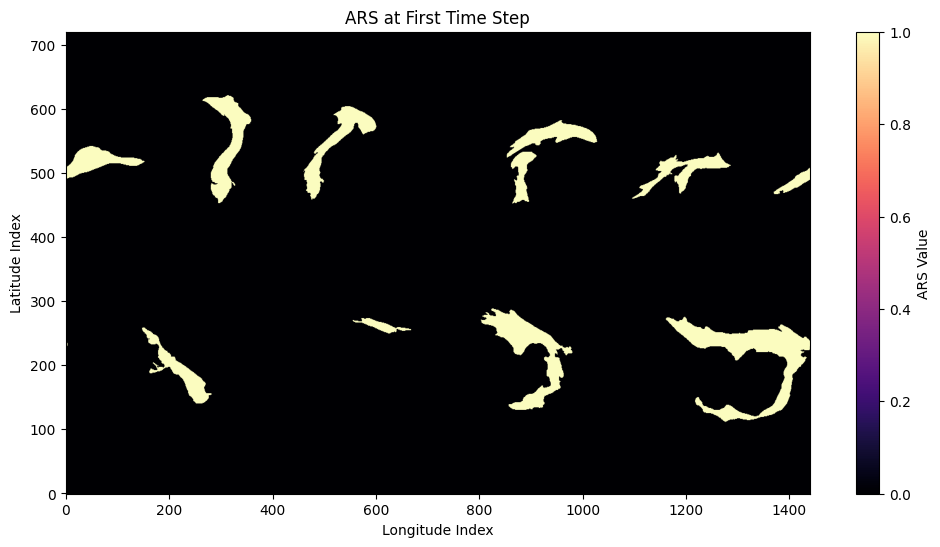

In [37]:
if 'ARS' in nc.variables:
    ars_data = nc.variables['ARS'][:]  
    print("ARS shape:", ars_data.shape) 

   
    ars_slice = ars_data[0, :, :]  

 
    plt.figure(figsize=(12, 6))
    plt.imshow(ars_slice, cmap='magma', origin='lower', aspect='auto')
    plt.colorbar(label='ARS Value')
    plt.title('ARS at First Time Step')
    plt.xlabel('Longitude Index')
    plt.ylabel('Latitude Index')
    plt.show()
else:
    print("Variable 'IWV' not found in the dataset.")

In [17]:
if 'ARS' in nc.variables:
    ar_data = nc.variables['AR_Shape'][:]  
    print("AR_Shape shape:", ar_data.shape)

    
    ar_data = (ar_data - np.min(ar_data)) / (np.max(ar_data) - np.min(ar_data))

  
    def create_spatiotemporal_sequences(data, seq_length):
        X, y = [], []
        for i in range(len(data) - seq_length):
            X.append(data[i:i + seq_length, :, :])  
            y.append(data[i + seq_length, :, :])  
        return np.array(X), np.array(y)

    seq_length = 10   
    X, y = create_spatiotemporal_sequences(ar_data, seq_length)

    print("Input shape (X):", X.shape)  
    print("Target shape (y):", y.shape)   
else:
    print("Variable 'AR_Shape' not found in the dataset.")

KeyError: 'AR_Shape'

In [2]:


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, BatchNormalization, Conv2D

# ConvLSTM2D model
model = Sequential([
    ConvLSTM2D(filters=32, kernel_size=(3, 3), activation='tanh',
               input_shape=(seq_length, X.shape[2], X.shape[3], 1),
               padding='same', return_sequences=True),
    BatchNormalization(),
    ConvLSTM2D(filters=32, kernel_size=(3, 3), activation='tanh',
               padding='same', return_sequences=False),
    BatchNormalization(),
    Conv2D(filters=1, kernel_size=(3, 3), activation='sigmoid', padding='same')  # Output spatial field
])

 
model.compile(optimizer='adam', loss='binary_crossentropy' if y.max() <= 1 else 'mse')

 
model.summary()

X = X[..., np.newaxis]  
y = y[..., np.newaxis]   

 
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

 
history = model.fit(X_train, y_train, epochs=20, batch_size=8, validation_data=(X_test, y_test))

 
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

 

AttributeError: NetCDF: Attribute not found

In [ ]:
#ConvLSTM2D model
model = Sequential([
    ConvLSTM2D(filters=32, kernel_size=(3, 3), activation='tanh',
               input_shape=(seq_length, X.shape[2], X.shape[3], 1),
               padding='same', return_sequences=True),
    BatchNormalization(),
    ConvLSTM2D(filters=32, kernel_size=(3, 3), activation='tanh',
               padding='same', return_sequences=False),
    BatchNormalization(),
    Conv2D(filters=1, kernel_size=(3, 3), activation='sigmoid', padding='same')  # Output spatial field
])

 
model.compile(optimizer='adam', loss='binary_crossentropy' if y.max() <= 1 else 'mse')

 
model.summary()

In [ ]:
predictions = model.predict(X_test)

 
idx = 0   
plt.figure(figsize=(12, 6))

 
plt.subplot(1, 2, 1)
plt.imshow(y_test[idx, :, :, 0], cmap='viridis', origin='lower')
plt.title("Actual Atmospheric River Shape")
plt.colorbar()

# predicted
plt.subplot(1, 2, 2)
plt.imshow(predictions[idx, :, :, 0], cmap='viridis', origin='lower')
plt.title("Predicted Atmospheric River Shape")
plt.colorbar()

plt.show()

In [ ]:

ti = 4 * (day - 1) + hour // 6
dfa = xr.open_dataset(f'out_{year}{month:02d}.nc')

ARS = dfa.shape[0,ti,0,:,:].values
ARS = np.where(ARS > 0, 1, 0)     

mdfa = xr.open_dataset(f'mout_{year}{month:02d}.nc')

MARS = mdfa.shape[0,ti,0,:,:].values
MARS = np.where(MARS > 0, 1, 0)       

In [4]:
fp = 'era5dara_194001.nc'
nc = netCDF4.Dataset(fp)

 
print(nc.variables.keys())  
print(nc.dimensions.keys())   
for var in nc.variables.values():
    print(var)   

dict_keys(['longitude', 'latitude', 'time', 'Qu', 'Qv', 'IWV', 'CRH', 'TPR', 'TP6H', 'GWS10m', 'LTMT', 'T2m', 'MSLP', 'ARS', 'MARS'])
dict_keys(['longitude', 'latitude', 'time'])
<class 'netCDF4.Variable'>
float32 longitude(longitude)
    long_name: longitude
    units: degrees_east
unlimited dimensions: 
current shape = (1440,)
filling off
<class 'netCDF4.Variable'>
float32 latitude(latitude)
    long_name: latitude
    units: degrees_north
unlimited dimensions: 
current shape = (721,)
filling off
<class 'netCDF4.Variable'>
float32 time(time)
    long_name: time
    dtype: datetime64[ns]
    units: minutes since 1940-01-01 00:00
unlimited dimensions: time
current shape = (124,)
filling off
<class 'netCDF4.Variable'>
float32 Qu(time, latitude, longitude)
    long_name: Vertical integral of eastward water vapour flux
    units: kg m**-1 s**-1
    integration_limit: From surface to 200 hPa
unlimited dimensions: time
current shape = (124, 721, 1440)
filling off
<class 'netCDF4.Variable'>


In [7]:
import torch
from torch.utils.data import DataLoader, Dataset
import xarray as xr
import metpy.calc as mc
import numpy as np

 
time = nc.variables['time'][:]  
lat = nc.variables['latitude'][:] 
lon = nc.variables['longitude'][:]   

In [8]:
input_vars = ['IWV', 'Qv', 'Qu']   
X = np.stack([nc.variables[v][:] for v in input_vars], axis=-1)  

 
ARS = nc.variables['ARS'][:]   

 
X = (X - np.min(X)) / (np.max(X) - np.min(X))  

In [9]:
# sequences for RNN
seq_length = 10  
def create_sequences(X, y, seq_length):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_length):
        X_seq.append(X[i:i + seq_length, :, :, :])  
        y_seq.append(y[i + seq_length, :, :])       
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X, ARS, seq_length)

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

 
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [11]:
class ARDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = ARDataset(X_train, y_train)
test_dataset = ARDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

print(f"Train dataset size: {len(train_dataset)}, Test dataset size: {len(test_dataset)}")

Train dataset size: 91, Test dataset size: 23


In [12]:
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, seq_length, lat_dim, lon_dim):
        super(RNNModel, self).__init__()
        self.lstm = nn.LSTM(
            input_size=lat_dim * lon_dim * input_dim, 
            hidden_size=hidden_dim, 
            num_layers=2, 
            batch_first=True
        )
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, lat_dim * lon_dim),
            nn.Sigmoid()   
        )
        self.lat_dim = lat_dim
        self.lon_dim = lon_dim

In [13]:
def forward(self, x):
        batch_size, seq_len, lat, lon, features = x.size()
        x = x.view(batch_size, seq_len, -1)  
        lstm_out, _ = self.lstm(x) 
        last_hidden_state = lstm_out[:, -1, :]  
        out = self.fc(last_hidden_state) 
        return out.view(batch_size, self.lat_dim, self.lon_dim)  #<-- reshape to grid

In [14]:
#parameters
input_dim = X_train.shape[-1]  
hidden_dim = 128
output_dim = X_train.shape[2] * X_train.shape[3]
seq_length = 10
lat_dim, lon_dim = X_train.shape[2], X_train.shape[3]

 
model = RNNModel(input_dim, hidden_dim, output_dim, seq_length, lat_dim, lon_dim)
print(model)

RNNModel(
  (lstm): LSTM(3114720, 128, num_layers=2, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=128, out_features=1038240, bias=True)
    (1): Sigmoid()
  )
)


In [15]:
 
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [24]:
import torch
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers, dropout=0.5):
        super(RNNModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.rnn = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout)

        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        out, _ = self.rnn(x) 
        out = out[:, -1, :] 
        out = self.fc(out)
        return out


In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

num_epochs = 20
print(f"Training on: {device}")

Training on: cpu


In [27]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        
        print(f"Outputs shape: {outputs.shape}, Target shape: {y_batch.shape}")

        loss = criterion(outputs, y_batch)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) 
        optimizer.step()
        
        train_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {train_loss / len(train_loader):.4f}")

torch.cuda.empty_cache()

NotImplementedError: Module [RNNModel] is missing the required "forward" function

In [ ]:
model.eval()
test_loss = 0.0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()

print(f"Test Loss: {test_loss / len(test_loader):.4f}")

# visualization
import matplotlib.pyplot as plt
with torch.no_grad():
    X_example, y_example = test_dataset[0]
    X_example = X_example.unsqueeze(0).to(device) 
    y_pred = model(X_example).cpu().numpy()

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(y_example.numpy(), cmap='Blues')
    plt.title('Actual ARS')

    plt.subplot(1, 2, 2)
    plt.imshow(y_pred[0], cmap='Blues')
    plt.title('Predicted ARS')
    plt.show()

In [60]:
from matplotlib import pyplot as plt
import pandas as pd
import netCDF4
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


fp = 'era5dara_194001.nc' 
nc = netCDF4.Dataset(fp)

input_vars = ['IWV', 'Qv', 'Qu', 'CRH', 'LTMT', 'T2m', 'MSLP'] 
X = np.stack([nc.variables[v][:] for v in input_vars], axis=-1)

for i in range(X.shape[-1]):
    X[:, :, :, i] = (X[:, :, :, i] - np.min(X[:, :, :, i])) / (np.max(X[:, :, :, i]) - np.min(X[:, :, :, i]))

ARS = nc.variables['ARS'][:]

X_flat = X.reshape(-1, X.shape[-1])
y_flat = ARS.flatten()

mask = ~np.isnan(y_flat)
X_flat = X_flat[mask]
y_flat = y_flat[mask]

X_train, X_test, y_train, y_test = train_test_split(X_flat, y_flat, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.9675
              precision    recall  f1-score   support

         0.0       0.97      1.00      0.98  24735261
         1.0       0.72      0.28      0.41   1013091

    accuracy                           0.97  25748352
   macro avg       0.85      0.64      0.70  25748352
weighted avg       0.96      0.97      0.96  25748352



In [ ]:
input_vars = ['IWV', 'Qv', 'Qu', 'TPR', 'TP6H', 'GWS10m', 'time', 'longitude', 'latitude', 'CRH', 'LTMT', 'T2m', 'MSLP']  # Adjust as needed
X = np.stack([nc.variables[v][:] for v in input_vars], axis=-1)

X_flat = X.reshape(-1, X.shape[-1])
y_flat = ARS.flatten()

mask = ~np.isnan(y_flat)
X_flat = X_flat[mask]
y_flat = y_flat[mask]

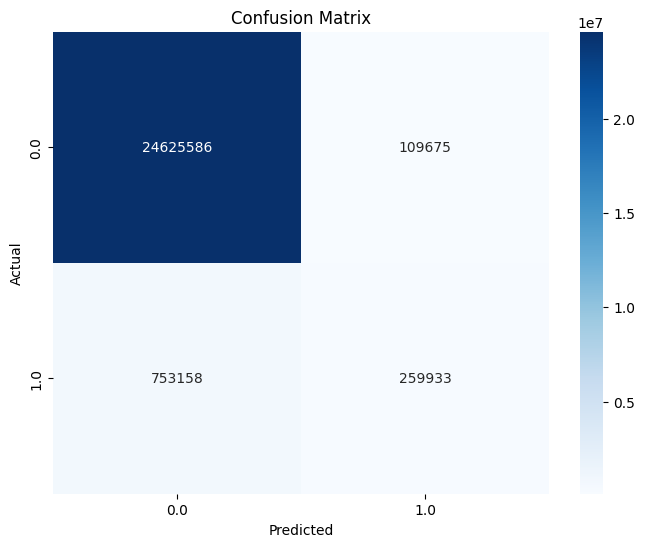

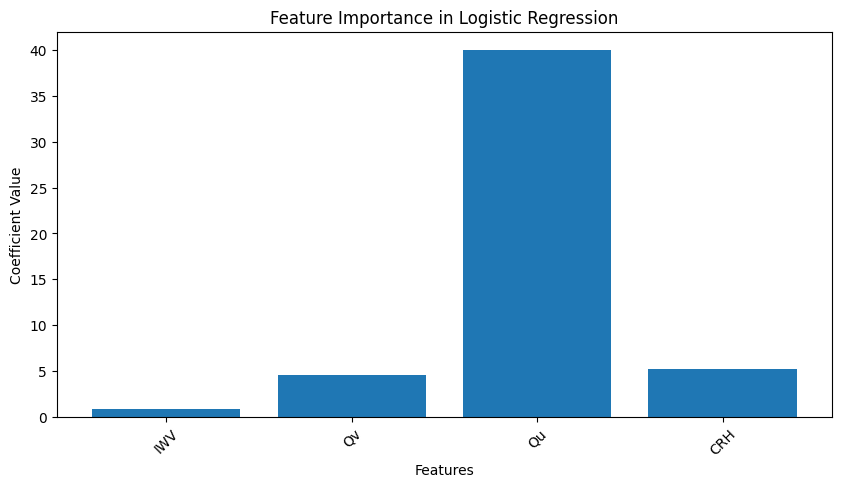

In [40]:
from matplotlib import pyplot as plt
import pandas as pd
import netCDF4
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_flat), yticklabels=np.unique(y_flat))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(input_vars, model.coef_[0])
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Feature Importance in Logistic Regression')
plt.xticks(rotation=45)
plt.show()

In [65]:
input_vars = ['IWV', 'Qv', 'Qu', 'TPR', 'TP6H', 'GWS10m', 'CRH', 'LTMT', 'T2m', 'MSLP']

 
valid_vars = []
for v in input_vars:
    if v in nc.variables and nc.variables[v].shape == nc.variables['IWV'].shape:  # Replace 'IWV' with a known correct shape
        valid_vars.append(v)
    else:
        print(f"Skipping {v} due to shape mismatch: {nc.variables[v].shape}")

print(f"Using variables: {valid_vars}")

X = np.stack([nc.variables[v][:] for v in valid_vars], axis=-1)

epsilon = 1e-8 
for i in range(X.shape[-1]):
    min_val = np.min(X[:, :, :, i])
    max_val = np.max(X[:, :, :, i])
    X[:, :, :, i] = (X[:, :, :, i] - min_val) / (max_val - min_val + epsilon)

ARS = nc.variables['ARS'][:] 

X_flat = X.reshape(-1, X.shape[-1])
y_flat = ARS.flatten()

mask = ~np.isnan(y_flat)
X_flat = X_flat[mask]
y_flat = y_flat[mask]

Using variables: ['IWV', 'Qv', 'Qu', 'TPR', 'TP6H', 'GWS10m', 'CRH', 'LTMT', 'T2m', 'MSLP']


In [58]:
input_vars = ['IWV', 'Qv', 'Qu', 'CRH', 'LTMT', 'T2m', 'MSLP']  # Adjust as needed

In [66]:
df = pd.DataFrame(X_flat, columns=input_vars)
df['ARS'] = y_flat 

print(df.head())

        IWV       Qv        Qu  TPR  TP6H  GWS10m      CRH      LTMT  \
0  0.022071  0.50249  0.487435  NaN   NaN     NaN  0.36907  0.296106   
1  0.022071  0.50249  0.487435  NaN   NaN     NaN  0.36907  0.296106   
2  0.022071  0.50249  0.487435  NaN   NaN     NaN  0.36907  0.296106   
3  0.022071  0.50249  0.487435  NaN   NaN     NaN  0.36907  0.296106   
4  0.022071  0.50249  0.487435  NaN   NaN     NaN  0.36907  0.296106   

        T2m      MSLP  ARS  
0  0.316467  0.785786  0.0  
1  0.316467  0.785786  0.0  
2  0.316467  0.785786  0.0  
3  0.316467  0.785786  0.0  
4  0.316467  0.785786  0.0  


In [41]:
import torch
from torch.utils.data import DataLoader, Dataset
import xarray as xr
import metpy.calc as mc
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import netCDF4
fp='era5dara_194001.nc'
nc = netCDF4.Dataset(fp)


In [42]:
input_vars = ['IWV', 'Qv', 'Qu', 'CRH', 'LTMT', 'T2m', 'MSLP'] 
X = np.stack([nc.variables[v][:] for v in input_vars], axis=-1) 
for i in range(X.shape[-1]):
    X[:, :, :, i] = (X[:, :, :, i] - np.min(X[:, :, :, i])) / (np.max(X[:, :, :, i]) - np.min(X[:, :, :, i]))

ARS = nc.variables['ARS'][:]
print(X.shape, ARS.shape)

(124, 721, 1440, 7) (124, 721, 1440)


In [43]:
resolution_red = 20
red_ARS = ARS[:, ::resolution_red, ::resolution_red]
red_X = X[:, ::resolution_red, ::resolution_red, :]

print(red_X.shape, red_ARS.shape)

(124, 37, 72, 7) (124, 37, 72)


In [44]:
red_ARS = red_ARS.reshape(-1)
red_X = red_X.reshape(-1, X.shape[-1])

In [45]:
print(red_X.shape, red_ARS.shape)

(330336, 7) (330336,)


In [46]:
seq_len = 10
X_seq = []
ARS_seq = []
jumper = 10

for i in range(0, len(red_X) - seq_len, jumper):
    X_seq.append(red_X[i:i+seq_len])
    ARS_seq.append(red_ARS[i+seq_len])

X_seq = np.array(X_seq)
ARS_seq = np.array(ARS_seq)

print(X_seq.shape, ARS_seq.shape)

(33033, 10, 7) (33033,)


In [ ]:
#mps_device = torch.device("mps")

In [47]:
class SequenceDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

In [48]:
from torch.utils.data import DataLoader, Dataset, random_split

def split_dataset(dataset, train_ratio=0.8, val_ratio=0.1):
    total_size = len(dataset)
    train_size = int(total_size * train_ratio)
    val_size = int(total_size * val_ratio)
    test_size = total_size - train_size - val_size

    train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

    return train_set, val_set, test_set

In [49]:
batch_size = 32
dataset = SequenceDataset(X_seq, ARS_seq)
train_set, val_set, test_set = split_dataset(dataset, train_ratio=0.8, val_ratio=0.1)
 
data_loader_train = DataLoader(train_set, batch_size=batch_size, shuffle=True)
data_loader_val = DataLoader(val_set, batch_size=batch_size, shuffle=False)
data_loader_test = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [50]:
import torch.nn as nn

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)

        out = out[:, -1, :]

        out = self.fc(out)
        return out

In [51]:
# hyperparameters
input_size = X_seq.shape[-1]
hidden_size = 128
output_size = 2
num_layers = 1
learning_rate = 0.001
num_epochs = 30

model = RNNModel(input_size, hidden_size, output_size, num_layers)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [53]:

total_step = len(data_loader_train)
training_losses = []
validation_accuracies = []
for epoch in range(num_epochs):
    for i, (sequences, labels) in enumerate(data_loader_train):
        sequences, labels = sequences, labels

        outputs = model(sequences)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for sequences, labels in data_loader_val:
            sequences, labels = sequences, labels

            outputs = model(sequences)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    if num_epochs <= 20 or (epoch+1) % 5 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
        print(f"Validation Accuracy: {100 * correct / total}%")
    training_losses.append(loss.item())
    validation_accuracies.append(100 * correct / total)

TypeError: 'numpy.float32' object cannot be interpreted as an integer

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)

plt.plot(training_losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(validation_accuracies)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()


In [ ]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for sequences, labels in data_loader_test:
        sequences, labels = sequences, labels

        outputs = model(sequences)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Test Accuracy: {100 * correct / total}%")

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for sequences, labels in data_loader_test:
        outputs = model(sequences)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()